## Pull labels from Labelbox and create patches

In [28]:
import os

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']

In [29]:
CLASSES = {
    'unclassified': 0,
    'agriculture': 10,
    'bare_dark': 5,
    'bare_light': 4,
    'built': 6,
    'burn': 9,
    'cloud': 1,
    'flooded_vegetation': 3,
    'grass_dry': 12,
    'grass_verdant': 11,
    'shrubs': 8,
    'trees': 7,
    'water': 2
}

labelbox_dir = "./data/labelbox"
images_dir = f'{labelbox_dir}/images'
labels_dir = f'{labelbox_dir}/labels'


## Classification priority
- Lower classes get overwritten by higher ones
- Islands have priority over container

1. Cloud
2. Water
3. Flooded vegetation
4. Bare (light)
5. Bare (dark)
6. Built
7. Trees
8. Shrubs
9. Burn
10. Agriculture
11. Grass (verdant)
12. Grass (dry)

## Create patches with polygon labels

In [30]:
def is_island(target_polygon, polygon_list):
    for curr_poly in polygon_list:
        if target_polygon.within(curr_poly):
            return True
        
    return False

In [31]:
from datetime import datetime, timedelta
from labelbox import Client


def get_data_rows():
    client = Client(api_key=LABELBOX_API_KEY)
    project = client.get_project("clcrkcvn9281j07xybmww69pn")

    now = datetime.today()
    then = now - timedelta(days=60)

    data_rows = project.export_labels(download=True, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))    
    return data_rows


In [32]:
%reload_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import numpy as np
import os
from patchify import patchify
from shapely.geometry import box, Polygon
import rasterio
from rasterio.features import geometry_mask


from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization


RES_M = 10 # meters
INPUT_SIZE = 512 # pixels
NONZERO_MIN_PCT = 0.40 # percent

os.makedirs(labelbox_dir, exist_ok=True)    
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
    
    
data_rows = get_data_rows()    
print(f'{len(data_rows)} data rows')

    
# loop through each image (i.e. data row)
for row in data_rows:
        
    row_id = row['DataRow ID']
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    composite_cog_url = rgb_cog_url.replace('rgb_byte_cog', 'composite_float32_cog')
    job_name = composite_cog_url.split('/')[4]
    rgb_cog_src = rasterio.open(rgb_cog_url)
    
    print(rgb_cog_url)
    print(f'{len(labels)} labeled polygons')
    
    # load original composite raster
    with rasterio.open(f'./data/{job_name}/composite.tif') as composite_src:
        composite_shape = composite_src.shape
        composite_transform = composite_src.transform
        composite_data = composite_src.read(masked=True)

    # initialize all polygons for island test
    label_polygons = {
        label['featureId']: Polygon(label['geometry']['coordinates'][0])
        for label in labels
    }
        
    labels_data = np.zeros(composite_shape).astype(np.uint8)
        
    islands = []
    sorted_labels = sorted(labels, key=lambda lab: CLASSES[lab['value']], reverse=True)
    
    for label in sorted_labels:
        class_title = label['title']
        class_value = label['value']
        class_idx = CLASSES[class_value]
        
        label_id = label['featureId']
        polygon = label_polygons[label_id]
        polygon_mask = geometry_mask([polygon], composite_shape, composite_transform, invert=True)

        # test if current polygon completely surrounded by another
        # add islands after everything else
        test_polygons = label_polygons.copy()
        del test_polygons[label_id]
        is_poly_island = is_island(polygon, list(test_polygons.values()))
        
        if is_poly_island:
            islands.append((class_idx, polygon_mask))
        else:
            labels_data[polygon_mask] = class_idx
        
    for class_idx, polygon_mask in islands:
        labels_data[polygon_mask] = class_idx
 
    rgb_cog_src.close()

            
    # create patches

    composite_data = composite_data.transpose((1, 2, 0))
        
    image_patches = patchify(composite_data, (INPUT_SIZE, INPUT_SIZE, composite_data.shape[2]), step=INPUT_SIZE)
    label_patches = patchify(labels_data, (INPUT_SIZE, INPUT_SIZE), step=INPUT_SIZE)
    
    assert image_patches.shape[0] == label_patches.shape[0]
    assert image_patches.shape[1] == label_patches.shape[1]
    
    for irow in range(label_patches.shape[0]):
        for icol in range(label_patches.shape[1]):
            label_data = label_patches[irow, icol, :, :]
            nonzero_count = np.count_nonzero(label_data)
            label_data = np.ma.array(label_data, mask=(label_data==0))
                                    
            # ignore patches with little labels
            if nonzero_count / label_data.size >= NONZERO_MIN_PCT:     
                        
                print(irow, icol, round(nonzero_count / label_data.size, 2))
            
                image_data = image_patches[irow, icol, 0, :, :, :]
                image_data = np.ma.array(image_data, mask=(image_data==NODATA_FLOAT32))
                
                # full_mask will most often = label_data.mask
                full_mask = image_data.mask[:, :, 0] | label_data.mask
                label_data.mask = full_mask

                # apply full mask to image
                # move nbands to 0-th position
                shp = image_data.shape
                temp_shape = shp[2:] + shp[:2]
                full_mask = np.broadcast_to(full_mask, temp_shape).transpose((1, 2, 0))
                image_data.mask = full_mask
                       
                image_path = f'{images_dir}/{job_name}_{irow}_{icol}.tif'
                label_path = f'{labels_dir}/{job_name}_{irow}_{icol}.tif'
                
                x_min, y_min = rasterio.transform.xy(composite_transform, INPUT_SIZE*(irow+1), INPUT_SIZE*icol)
                x_max, y_max = rasterio.transform.xy(composite_transform, INPUT_SIZE*irow, INPUT_SIZE*(icol+1))             
                bbox = [x_min, y_min, x_max, y_max]
                                
                imagery.write_array_to_tif(image_data, image_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                imagery.write_array_to_tif(label_data, label_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)
                    
print('done')

1 data rows
https://data.smartcarte.earth/training/20220401_20220601_south/20220401_20220601_south_rgb_byte_cog.tif
288 labeled polygons
0 0 0.91
(512, 512, 4)
0 1 0.99
(512, 512, 4)
0 2 0.51
(512, 512, 4)
3 3 0.47
(512, 512, 4)
3 4 0.79
(512, 512, 4)
3 5 0.96
(512, 512, 4)
3 6 0.85
(512, 512, 4)
3 7 0.52
(512, 512, 4)
4 3 1.0
(512, 512, 4)
4 4 0.72
(512, 512, 4)
done


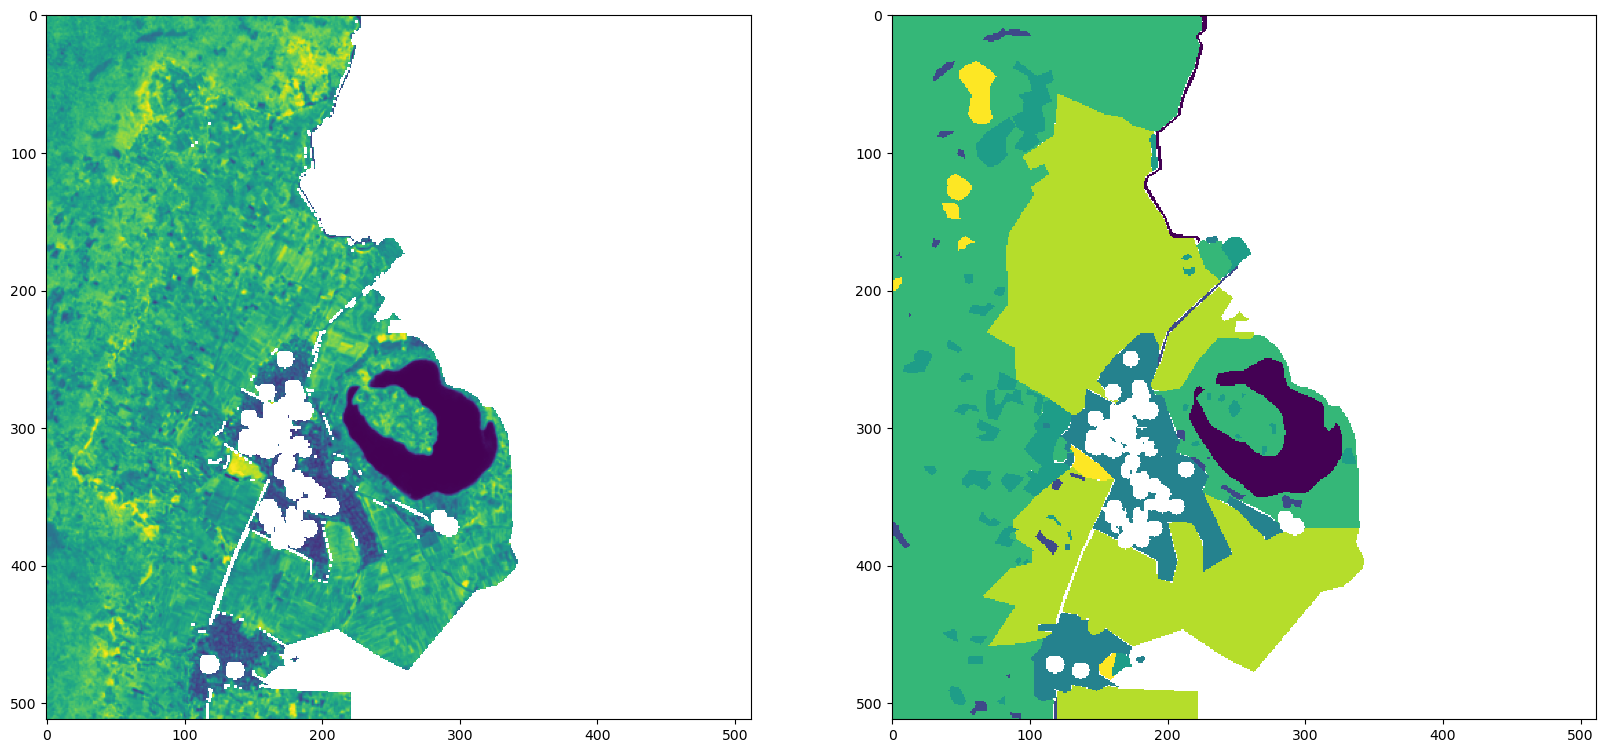

In [12]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import rasterio

import common.utilities.visualization as visualization


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

job = '20220401_20220601_south_0_2'

with rasterio.open(f"{images_dir}/{job}.tif") as f:
    data = f.read(masked=True)
    ax1.imshow(data[3, :, :])
    #visualization.plot_bands(data, bands=[2, 1, 0], ax=ax1, transpose=True)
    
with rasterio.open(f"{labels_dir}/{job}.tif") as f:
    data = f.read(1, masked=True)
    visualization.plot_bands(data, bands=1, ax=ax2, cmap="viridis")
    

## Data augmentation - rotate images

In [36]:
%reload_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization


image_paths = glob.glob(f'{images_dir}/20*[0-9].tif')


for image_path in image_paths:
    label_path = image_path.replace('/images/', '/labels/')
    
    with rasterio.open(image_path) as image_src:
        image_data = image_src.read(masked=True)
        bbox = list(image_src.bounds)
        
    with rasterio.open(label_path) as label_src:
        label_data = label_src.read(1, masked=True)
                
    for i in range(1, 4):
        
        image_rotated = np.rot90(image_data, k=i, axes=(1, 2))
        image_rotated = image_rotated.transpose((1, 2, 0))
        label_rotated = np.rot90(label_data, k=i, axes=(0, 1))
        
        image_rotated_path = image_path.replace('.tif', f'_{i*90}deg.tif')
        label_rotated_path = label_path.replace('.tif', f'_{i*90}deg.tif')
        
        imagery.write_array_to_tif(image_rotated, image_rotated_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
        imagery.write_array_to_tif(label_rotated, label_rotated_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)
                    
    

## Split folders into training / validation

In [37]:
import os
import shutil
import splitfolders


training_dir = "./data/trainingData"

if os.path.exists(training_dir):
    shutil.rmtree(training_dir)

splitfolders.ratio(labelbox_dir, output=training_dir, seed=314, ratio=(.8, .1, .1), group_prefix=None)

print('done')

Copying files: 80 files [00:04, 17.28 files/s]

done
